# scHopfield: Comprehensive Energy Landscape Analysis Pipeline

This notebook demonstrates the complete analysis capabilities of the scHopfield package for energy landscape analysis of single-cell dynamics. The analysis is organized into the following sections:

## Table of Contents
1. [Setup and Data Loading](#1-setup-and-data-loading)
2. [Data Preprocessing](#2-data-preprocessing) 
3. [Energy Landscape Analysis](#3-energy-landscape-analysis)
4. [Network Analysis](#4-network-analysis)
5. [Trajectory Simulation](#5-trajectory-simulation)
6. [Advanced Jacobian Analysis](#6-advanced-jacobian-analysis)
7. [Network Centrality Analysis](#7-network-centrality-analysis)
8. [Energy Landscape Dynamics](#8-energy-landscape-dynamics)
9. [Results Summary](#9-results-summary)

## 1. Setup and Data Loading

In [1]:
# Import required libraries
import anndata
import celloracle as co
import dynamo as dyn
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import scipy as scp
from scipy.spatial.distance import squareform
from scHopfield.analysis import LandscapeAnalyzer, NetworkAnalyzer
from scHopfield.utils.analysis_utilities import (
    change_spines, extract_cluster_colors, prepare_scaffold_matrix, get_correlation_table
)
import seaborn as sns
import sys
from tqdm import tqdm

In [2]:
%matplotlib inline

In [3]:
# Configuration and dataset selection
config_path = '/home/bernaljp/KAUST'
sys.path.append(config_path)
import config

name = 'Hematopoiesis'

In [4]:
# Load dataset
dataset = config.datasets[name]
cluster_key = config.cluster_keys[name]
velocity_key = config.velocity_keys[name]
spliced_key = config.spliced_keys[name]
title = config.titles[name]
order = config.orders[name]
dynamic_genes_key = config.dynamic_genes_keys[name]
degradation_key = config.degradation_keys[name]

adata = dyn.read_h5ad(config.data_path+dataset) if dataset.split('.')[1]=='h5ad' else dyn.read_loom(config.data_path+dataset)
adata

AnnData object with n_obs × n_vars = 1947 × 1956
    obs: 'batch', 'time', 'cell_type', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'new_Size_Factor', 'initial_new_cell_size', 'total_Size_Factor', 'initial_total_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'Size_Factor', 'initial_cell_size', 'ntr', 'cell_cycle_phase', 'leiden', 'control_point_pca', 'inlier_prob_pca', 'obs_vf_angle_pca', 'pca_ddhodge_div', 'pca_ddhodge_potential', 'acceleration_pca', 'curvature_pca', 'n_counts', 'mt_frac', 'jacobian_det_pca', 'manual_selection', 'divergence_pca', 'curv_leiden', 'curv_louvain', 'SPI1->GATA1_jacobian', 'jacobian', 'umap_ori_leiden', 'umap_ori_louvain', 'umap_ddhodge_div', 'umap_ddhodge_potential', 'curl_umap', 'divergence_umap', 'acceleration_umap', 'control_point_umap_ori', 'inlier_prob_umap_ori', 'obs_vf_angle_umap_ori', 'curvature_umap_ori'
    var: 'gene_name', 'gene_id', 'nCells', 'nCounts', 'pass_basic

## 2. Data Preprocessing

In [5]:
# Dataset-specific preprocessing
if name=='Hematopoiesis':
    bad_genes = np.unique(np.where(np.isnan(adata.layers[velocity_key].toarray()))[1])
    adata = adata[:,~np.isin(range(adata.n_vars),bad_genes)]
elif name=='Endocrinogenesis_preprocessed':
    pass
else:
    pp = dyn.preprocessing.Preprocessor()
    pp.preprocess_adata(adata, recipe='monocle')
    dyn.tl.dynamics(adata,cores=-1)
    dyn.tl.reduceDimension(adata,cores=-1)
    dyn.tl.cell_velocities(adata)
    dyn.tl.cell_wise_confidence(adata)
    if 'vel_params_names' in adata.uns:
        gamma_idx = adata.uns['vel_params_names'].index('gamma')
        adata.var['gamma'] = adata.varm['vel_params'][:,gamma_idx]

|-----------> plotting with basis key=X_umap
|-----------> skip filtering cell_type by stack threshold when stacking color because it is not a numeric type


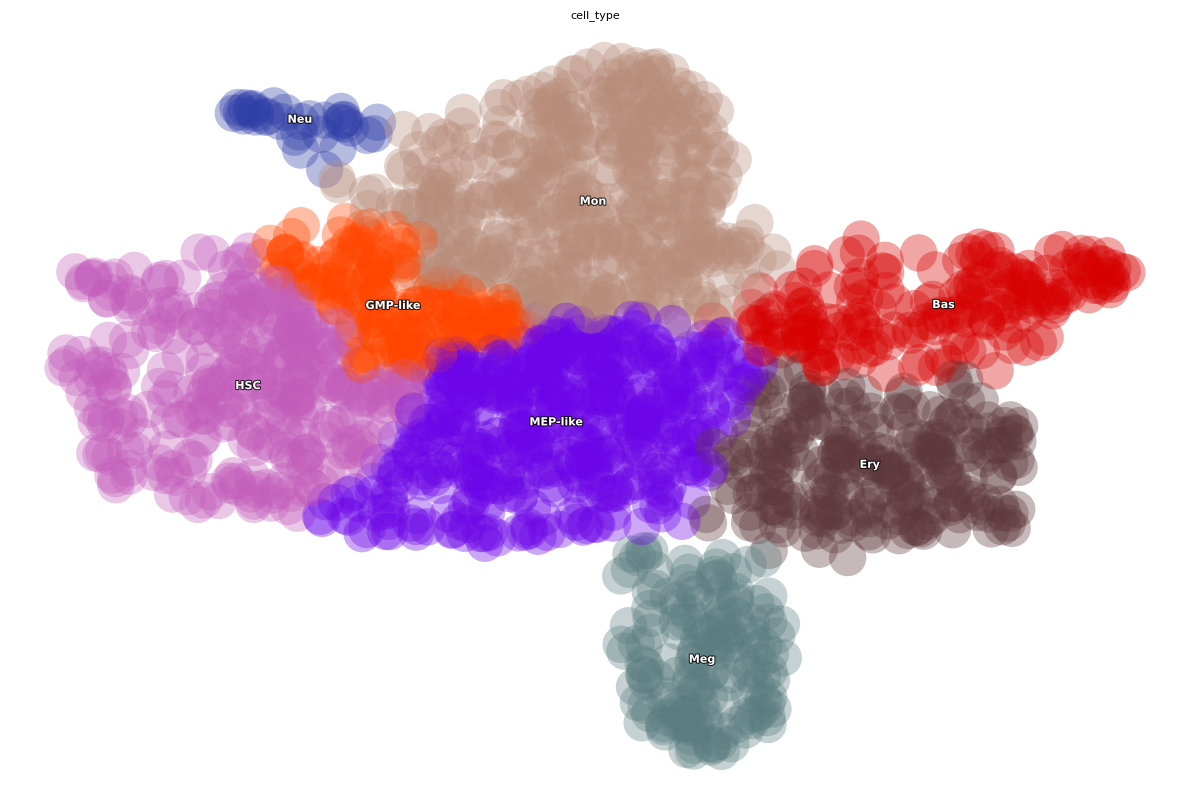

|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
|-----------> plotting with basis key=X_umap
|-----------> skip filtering cell_type by stack threshold when stacking color because it is not a numeric type


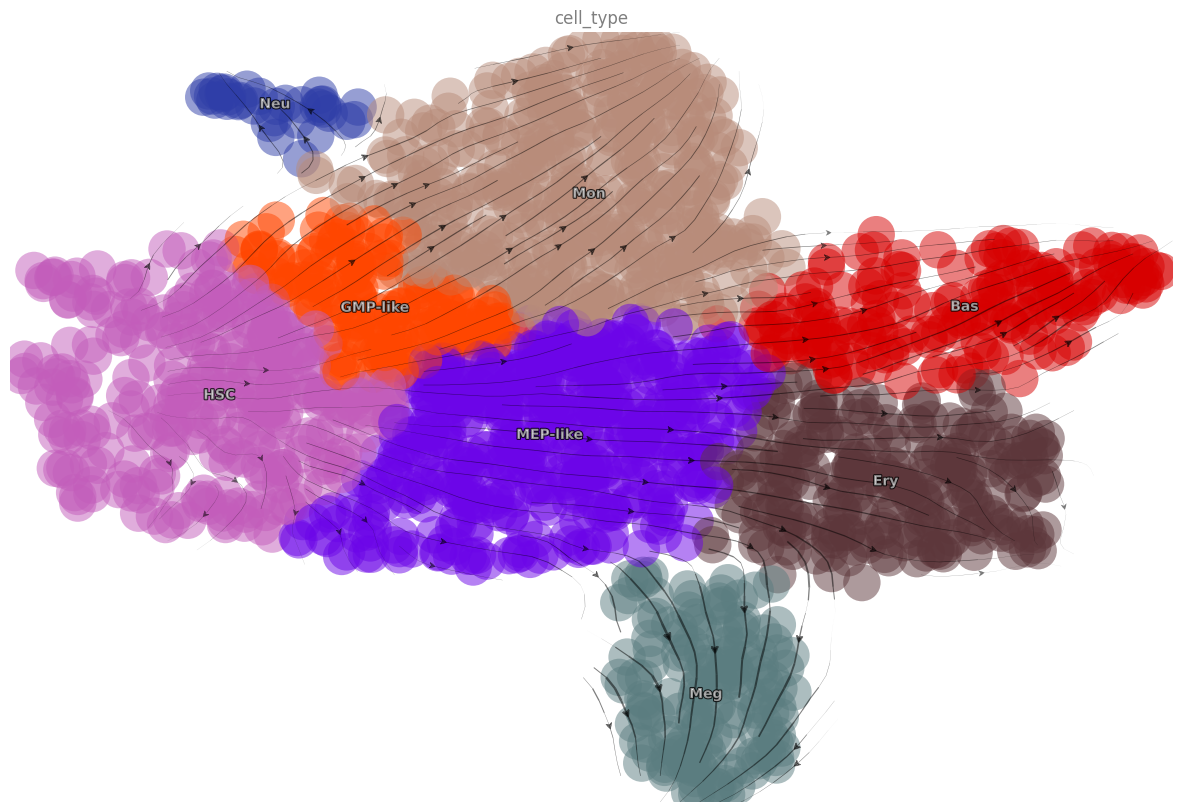

In [6]:
# Basic visualization
dyn.pl.scatters(adata, color=cluster_key, basis="umap", show_legend="on data", figsize=(15,10), save_show_or_return='return', pointsize=2, alpha=0.35)
plt.show()

ax = dyn.pl.streamline_plot(adata, color=cluster_key, basis="umap", show_legend="on data", show_arrowed_spines=False, 
                            figsize=(15,10), save_show_or_return='return', pointsize=2, alpha=0.35)
change_spines(ax)
plt.show()

In [7]:
# Extract colors for visualization
colors = extract_cluster_colors(adata, cluster_key)
print(f"Extracted colors for {len(colors)} clusters: {list(colors.keys())}")

Extracted colors for 8 clusters: ['Mon', 'Meg', 'MEP-like', 'Ery', 'Bas', 'GMP-like', 'HSC', 'Neu']


In [8]:
# Load and prepare scaffold matrix
base_GRN = co.data.load_mouse_scATAC_atlas_base_GRN()
base_GRN.drop(['peak_id'], axis=1, inplace=True)

scaffold = prepare_scaffold_matrix(adata, base_GRN)
print(f"Prepared scaffold matrix: {scaffold.shape}")
print(f"Non-zero elements: {(scaffold != 0).sum().sum()} / {scaffold.size}")

TFs in scaffold: 73
Target genes in scaffold: 1728
Prepared scaffold matrix: (1728, 1728)
Non-zero elements: 41693 / 2985984


## 3. Energy Landscape Analysis

In [9]:
# Initialize LandscapeAnalyzer
ls = LandscapeAnalyzer(adata, 
               spliced_matrix_key=spliced_key, 
               velocity_key=velocity_key, 
               genes=adata.var['use_for_dynamics'].values, 
               cluster_key=cluster_key, 
               w_threshold=1e-12,
            #    w_scaffold=scaffold.values, 
               scaffold_regularization=1e-2,
               only_TFs=True,
               criterion='MSE',
               batch_size=128,
               n_epochs=1000,
               refit_gamma=False,
               skip_all=True,
               device='cpu')

LandscapeAnalyzer initialized with 1728 genes and 8 clusters
Call fit_sigmoids() to start the analysis pipeline


In [10]:
# Manual analysis workflow
print("Starting manual analysis workflow...")

# Step 1: Fit sigmoid functions
print("1. Fitting sigmoid functions...")
ls.fit_sigmoids()

# Step 2: Write sigmoids to adata
print("2. Writing sigmoids to adata...")
ls.write_sigmoids()

# Step 3: Fit interaction matrices
print("3. Fitting interaction matrices...")
ls.fit_interactions()

# Step 4: Compute energies
print("4. Computing energies...")
ls.get_energies()

# Step 5: Write energies to adata
print("5. Writing energies to adata...")
ls.write_energies()

print("Manual analysis workflow completed!")

# Energy summary statistics
summary_stats = ls.adata.obs[[cluster_key,'Total_energy','Interaction_energy','Degradation_energy','Bias_energy']].groupby(cluster_key).describe()
for energy in summary_stats.columns.levels[0]:
    summary_stats[(energy,'cv')] = summary_stats[(energy,'std')]/summary_stats[(energy,'mean')]

summary_stats['Total_energy']

Starting manual analysis workflow...
1. Fitting sigmoid functions...
Fitting sigmoid functions to gene expression data...


/home/bernaljp/KAUST/scHopfield/utils/utilities.py:81: RuntimeWarning: divide by zero encountered in divide
  ty = np.log(y / (1 - y))
/home/bernaljp/KAUST/scHopfield/utils/utilities.py:81: RuntimeWarning: divide by zero encountered in log
  ty = np.log(y / (1 - y))


Successfully fitted sigmoids for 1728 genes
2. Writing sigmoids to adata...
3. Fitting interaction matrices...
Fitting interaction matrices using scaffold optimization...
Inferring interaction matrix W and bias vector I for cluster Mon
Inferring interaction matrix W and bias vector I for cluster Meg
Inferring interaction matrix W and bias vector I for cluster MEP-like
Inferring interaction matrix W and bias vector I for cluster Ery
Inferring interaction matrix W and bias vector I for cluster Bas
Inferring interaction matrix W and bias vector I for cluster GMP-like
Inferring interaction matrix W and bias vector I for cluster HSC
Inferring interaction matrix W and bias vector I for cluster Neu
Fitted interaction matrices for 8 clusters
4. Computing energies...
Computing energies using EnergyCalculator...
Computed energies for 8 clusters
5. Writing energies to adata...
Writing energies to adata.obs...
Energy values written to adata.obs
Manual analysis workflow completed!


count        mean        std         min         25%         50%  \
cell_type                                                                     
Bas        177.0 -226.057054  46.534673 -282.691098 -264.780284 -243.775513   
Ery        234.0 -245.647623  26.839575 -303.197837 -262.045880 -246.404385   
GMP-like   161.0  -95.265361  12.745731 -128.718418 -105.725014  -89.653988   
HSC        309.0 -113.722081   9.248091 -153.093643 -117.749364 -112.109916   
MEP-like   457.0 -194.829569  27.723814 -291.736030 -213.408912 -184.647652   
Meg        154.0 -309.001990  32.297649 -346.075856 -335.033483 -313.787741   
Mon        423.0 -318.569517  40.688797 -404.413992 -344.116936 -328.992788   
Neu         32.0 -118.074143   5.021739 -121.819904 -120.784705 -119.637909   

                  75%         max        cv  
cell_type                                    
Bas       -199.253865 -119.836182 -0.205854  
Ery       -233.326256 -134.210715 -0.109260  
GMP-like   -86.853057  -75.655961 -0.133792  
HSC       -107.403744  -97.053806 -0.081322  
MEP-like  -174.814360 -155.839626 -0.142298  
Meg       -297.310700 -180.691486 -0.104522  
Mon       -302.997730 -181.989940 -0.127723  
Neu       -118.483092  -97.570898 -0.042530

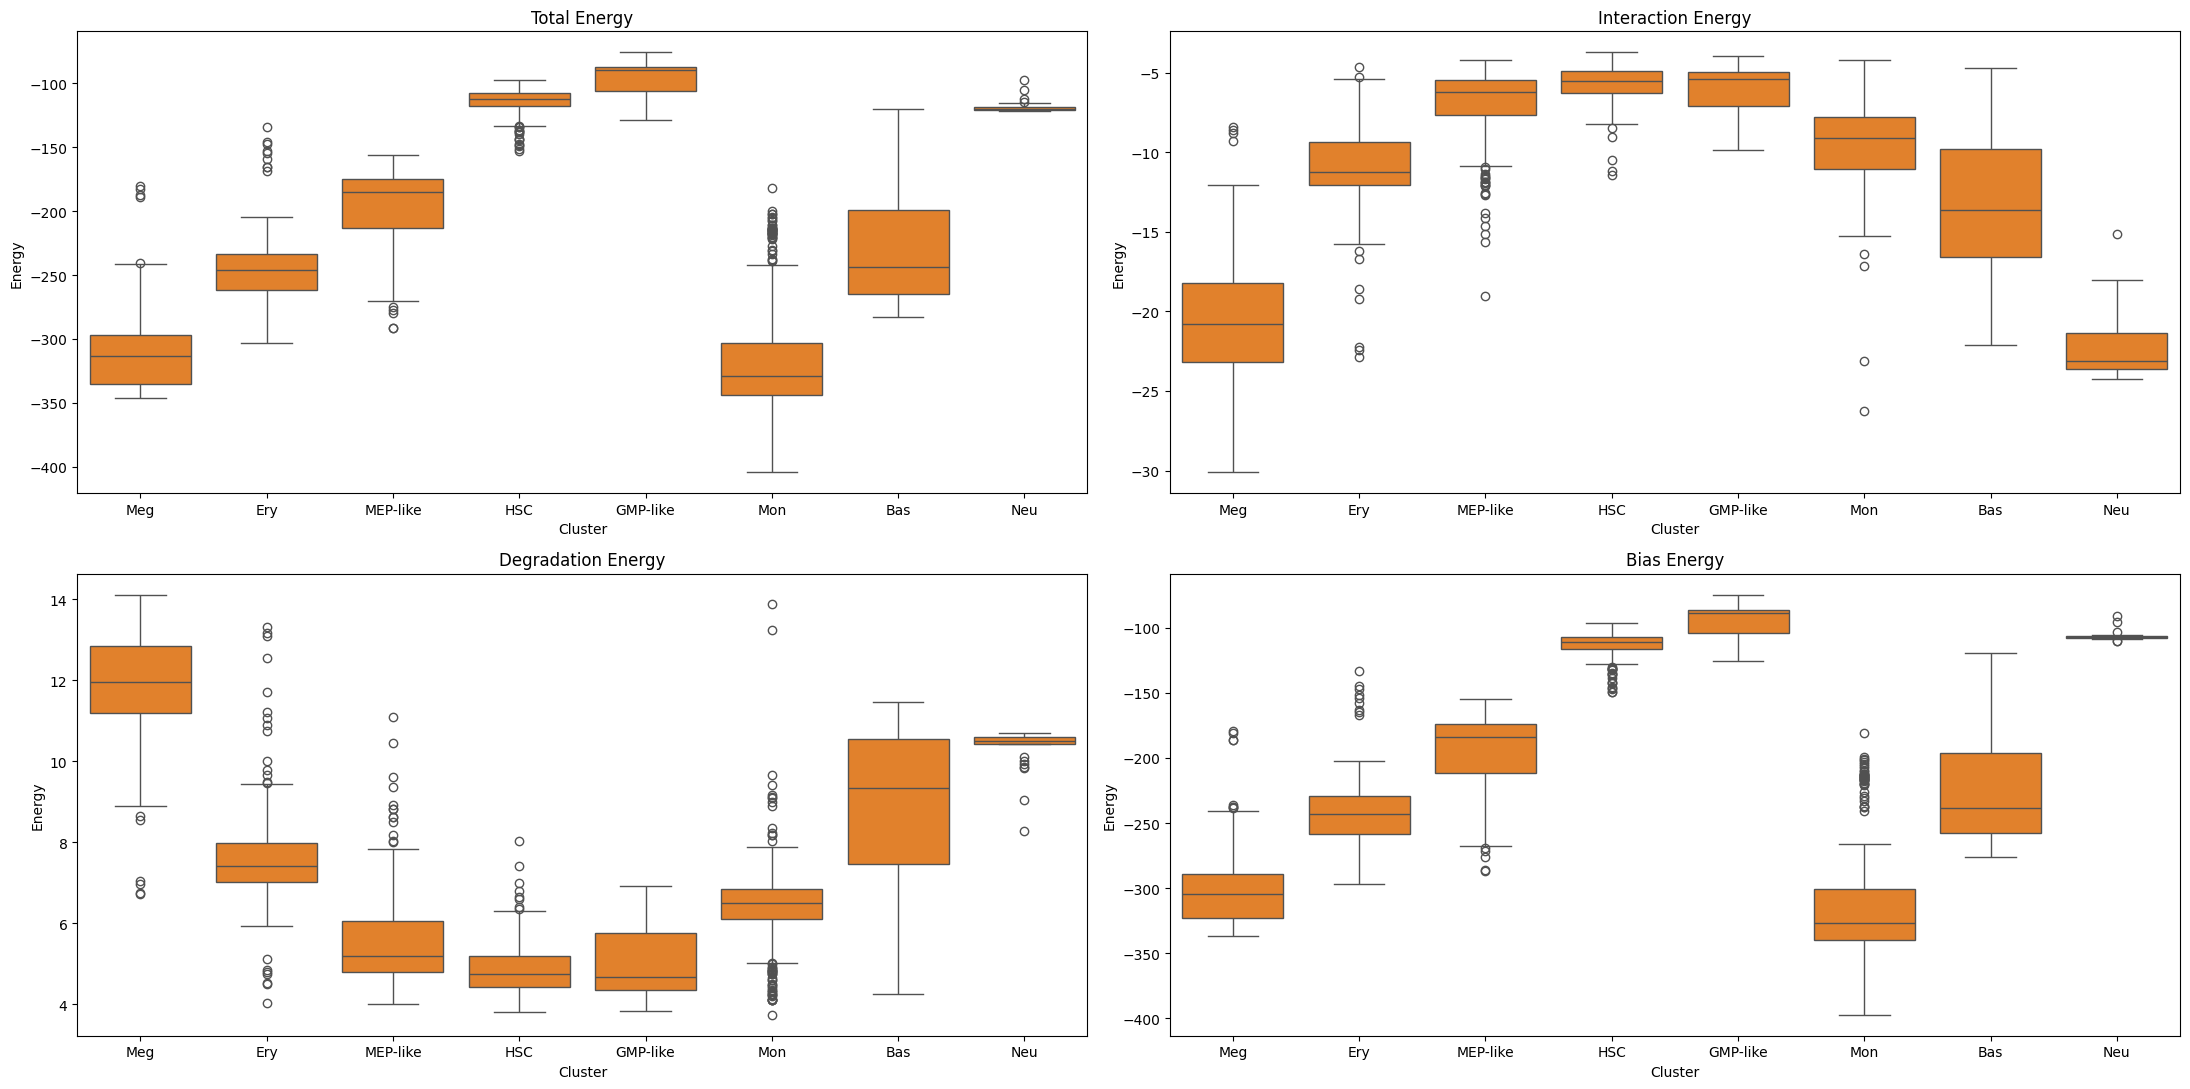

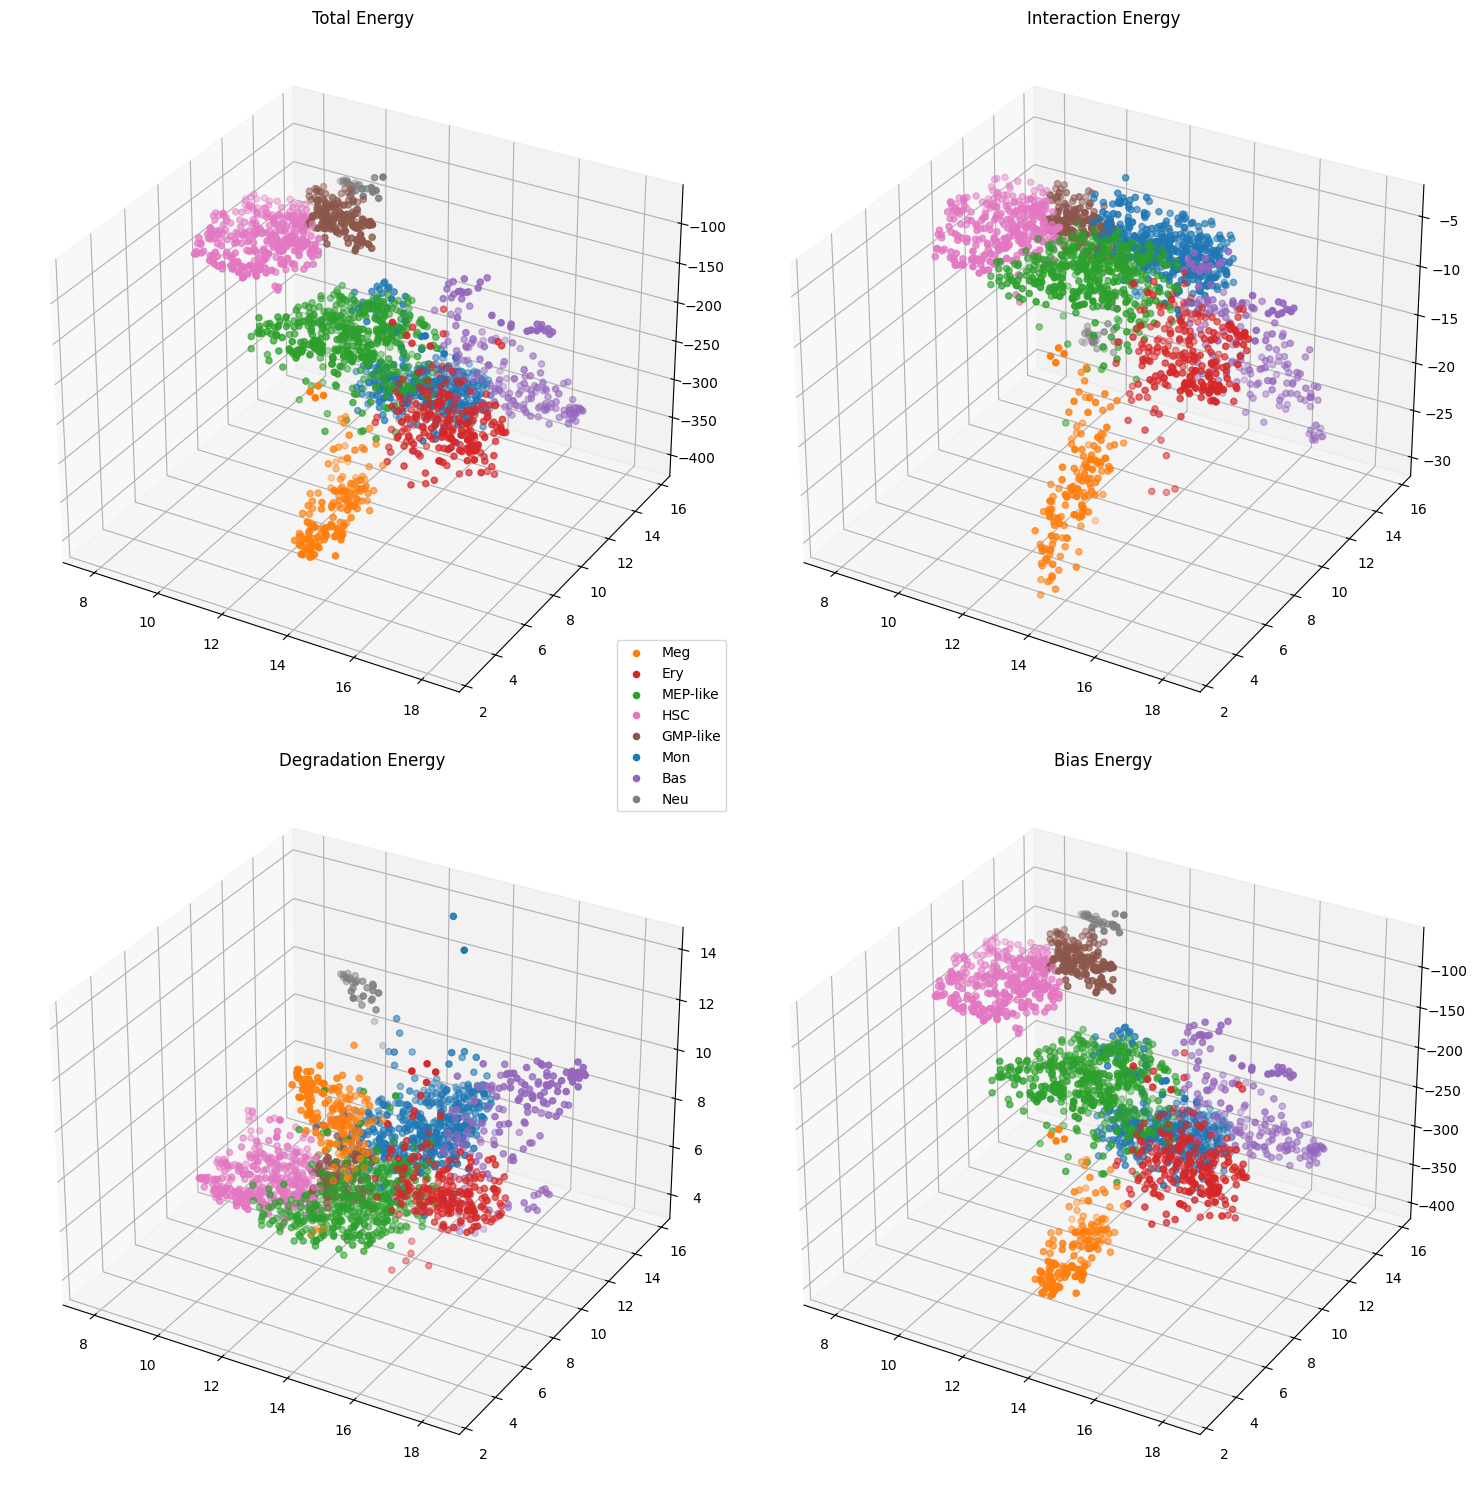

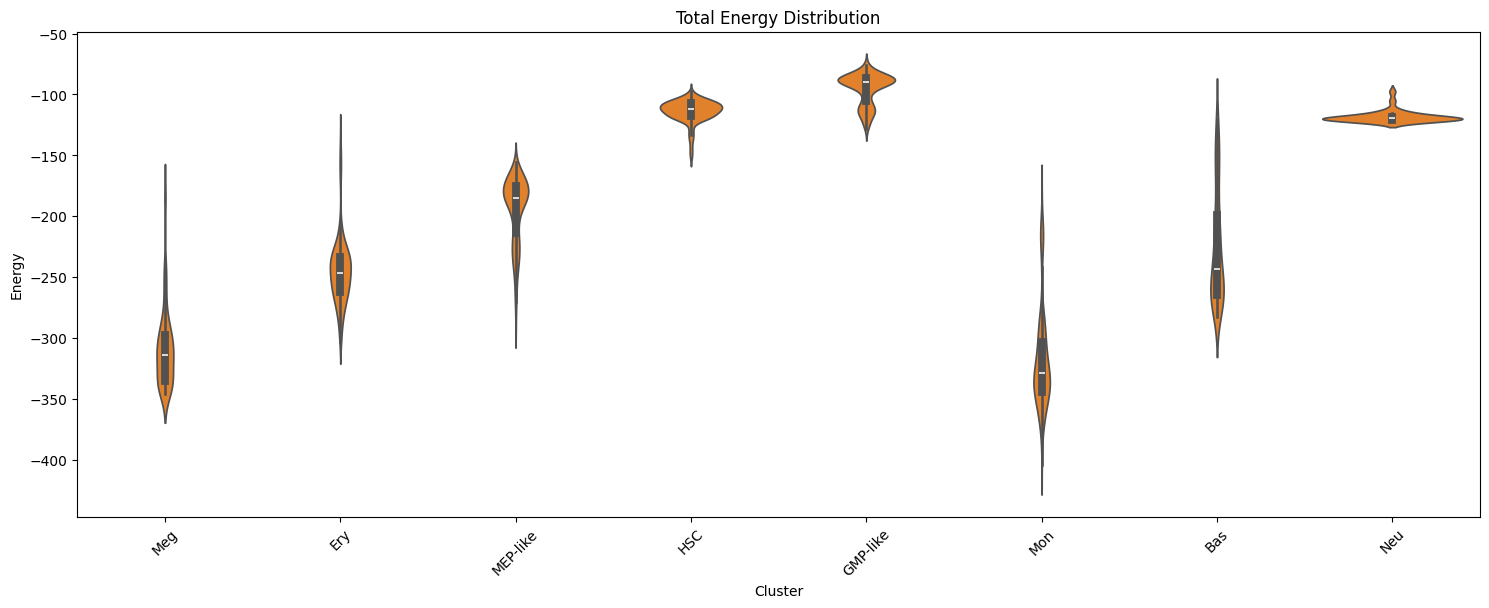

In [11]:
# Energy visualization
from scHopfield.visualization import EnergyPlotter
energy_plotter = EnergyPlotter(ls)

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=[colors[i] for i in order])
energy_plotter.plot_energy_boxplots(figsize=(22,11), order=order, colors=colors)
energy_plotter.plot_energy_scatters(figsize=(15,15), order=order)
plt.legend(loc='upper left', bbox_to_anchor=(-0.2, 1.2))
plt.show()

# Violin plots for energy distributions
energy_plotter.plot_energy_violin_plots(ls.E, order=order, figsize=(15, 6))
plt.title('Total Energy Distribution')
plt.show()

In [12]:
# Manual correlation analysis workflow
print("Starting correlation analysis...")

# Step 6: Compute energy-gene correlations
print("6. Computing energy-gene correlations...")
ls.energy_genes_correlation()

# Step 7: Compute cell type correlations
print("7. Computing cell type correlations...")
ls.celltype_correlation()

# Step 8: Compute network correlations
print("8. Computing network correlations...")
ls.network_correlations()

print("Correlation analysis workflow completed!")

# Top correlated genes table
correlation_table = get_correlation_table(ls, n_top_genes=10, which_correlation='total')
correlation_table

Starting correlation analysis...
6. Computing energy-gene correlations...
Computing energy-gene correlations...


/home/bernaljp/envs/scHopfield/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/bernaljp/envs/scHopfield/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Computed correlations for 8 clusters
7. Computing cell type correlations...
Computing cell type correlations...
Cell type correlations computed
8. Computing network correlations...
Computing network correlations...


/home/bernaljp/envs/scHopfield/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/bernaljp/envs/scHopfield/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Network correlations computed
Correlation analysis workflow completed!


Mon                   Meg                MEP-like              \
       Gene Correlation      Gene Correlation        Gene Correlation   
0      CD34    0.662112     FABP5    0.863113    HLA-DRB6    0.724703   
1      ELF1    0.633273    LPCAT2    0.820908        CD34    0.670553   
2  HLA-DRB6    0.602774     HPGDS    0.787841       DDIT4    0.603574   
3     DDIT4    0.593491  HLA-DRB6    0.784897       CRHBP    0.487616   
4     CASP7    0.564159    SEMA7A    0.783236       FABP5    0.463879   
5      MEST    0.525759    PDZD11    0.781232     ST13P19    0.463341   
6     MATR3    0.520480     ZNRF1    0.779244  AC104619.1    0.432472   
7      ASPM    0.519118      SRA1    0.771262     RPS2P48    0.430606   
8   HERC2P3    0.508271    CEP250    0.761493         ERG    0.417320   
9     UBE4A    0.491672   RABGGTA    0.740717        CTSG    0.408183   

          Ery                   Bas              GMP-like              \
         Gene Correlation      Gene Correlation      Gene Correlation   
0       DDIT4    0.653906      ARV1    0.800677  HLA-DRB6    0.726121   
1        CD34    0.632333    RPL18A    0.790753    CLASRP    0.600190   
2  AC104619.1    0.629172  HLA-DRB6    0.785393     DDIT4    0.596536   
3       FABP5    0.615676      EXO1    0.783865   RPS2P48    0.587937   
4    HLA-DRB6    0.559491    CTDSPL    0.772142     GRAP2    0.536456   
5       MATR3    0.517800     FABP5    0.770652    ADGRG6    0.514185   
6         ERG    0.508490    ABI3BP    0.763576     MATR3    0.506978   
7       MYPOP    0.503798      RCL1    0.749414   ST13P19    0.506096   
8     PIK3C2B    0.459862      CD34    0.738963    GCSHP5    0.500580   
9       TUBB6    0.459412      SNCA    0.735308    DNAJA4    0.489488   

        HSC                   Neu              
       Gene Correlation      Gene Correlation  
0  HLA-DRB6    0.412797     TOP2A    0.940484  
1  KIAA0040    0.352099  SLC25A21    0.903530  
2   RPS2P48    0.339901     AGFG1    0.896031  
3    ADAM15    0.324472     IDH3A    0.894511  
4     MATR3    0.309684   DYNLT2B    0.892844  
5      FPGT    0.305014    NSA2P3    0.890261  
6      CTSG    0.304193  RNASEH2A    0.890222  
7      ARV1    0.302892     ACSS1    0.886781  
8     TAFA5    0.296267    KLHDC2    0.883409  
9     DDIT4    0.295281  TMEM120B    0.880071

Plotting top 10 correlated genes for total energy...


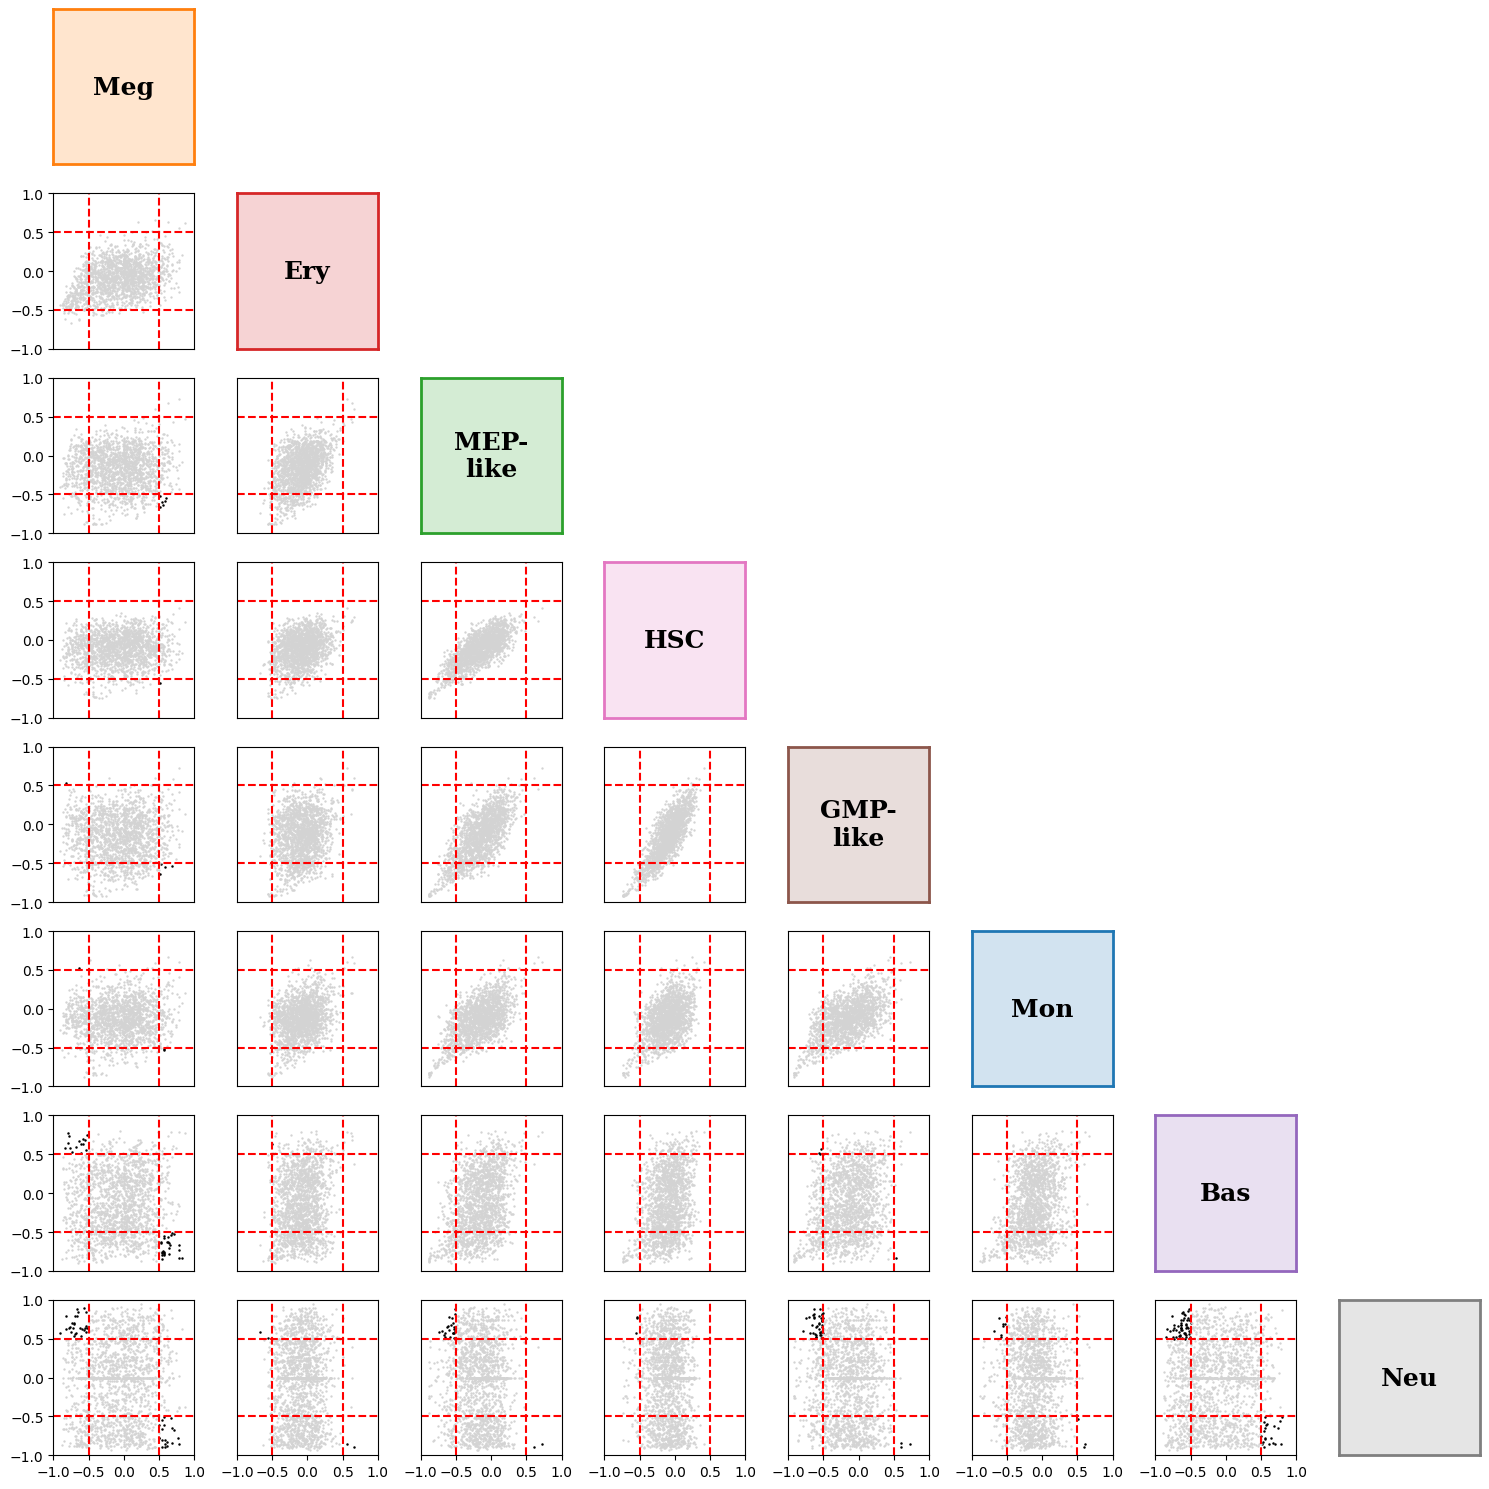

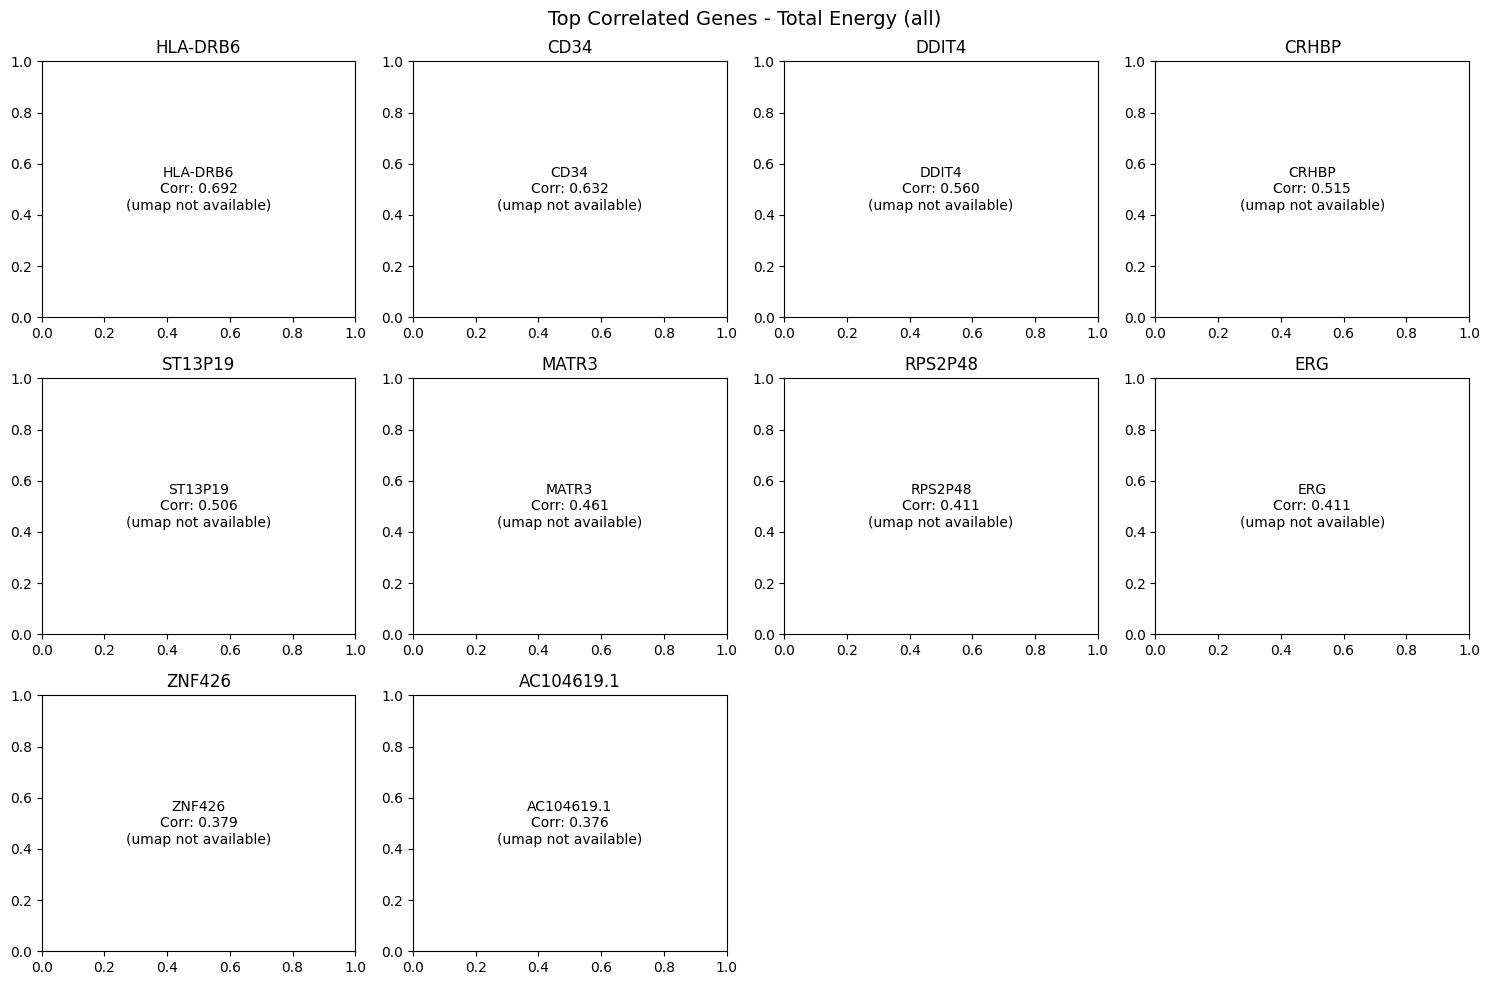

In [13]:
# Correlation visualization
from scHopfield.visualization import EnergyCorrelationPlotter
corr_plotter = EnergyCorrelationPlotter(ls)

corr_plotter.plot_correlations_grid(colors=colors, order=order, energy='total', figsize=(15, 15))
ls.plot_high_correlation_genes(top_n=10, energy='total', cluster='all', absolute=False, basis='umap', figsize=(15, 10))

## 4. Network Analysis

Computing cell type correlations...
Cell type correlations computed


<Figure size 900x300 with 0 Axes>

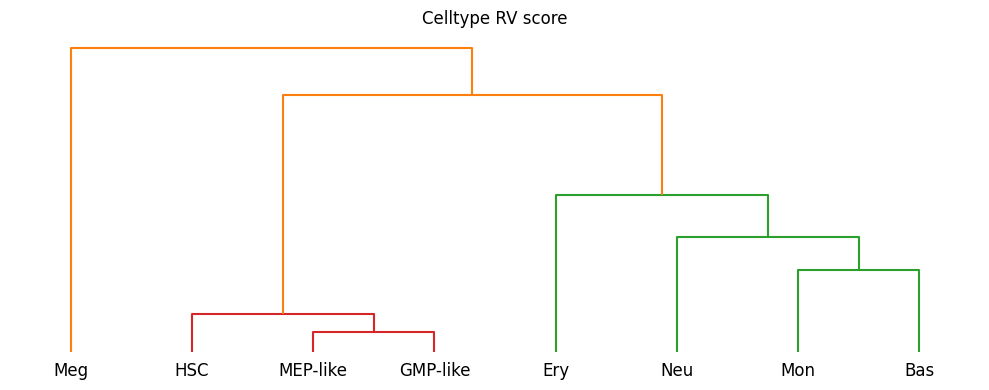

In [14]:
# Cell-type correlations
ls.celltype_correlation()

# Dendrogram visualization
plt.figure(figsize=(9, 3))
Z = scp.cluster.hierarchy.linkage(squareform(1-ls.cells_correlation), 'complete', )
fig,axs = plt.subplots(1,1,figsize=(10, 4), tight_layout=True)
scp.cluster.hierarchy.dendrogram(Z, labels = ls.cells_correlation.index, ax=axs)
axs.get_yaxis().set_visible(False)
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
axs.spines['bottom'].set_visible(False)
axs.spines['left'].set_visible(False)
axs.set_title('Celltype RV score')
plt.show()

In [15]:
# # Network correlations
# ls.network_correlations()

# # Network correlation visualization
# metrics = ['jaccard', 'hamming', 'euclidean', 'pearson', 'pearson_bin', 'mean_col_corr', 'singular']
# fig, axes = plt.subplots(2, 4, figsize=(20, 10))
# axes = axes.flatten()

# for i, metric in enumerate(metrics):
#     if hasattr(ls, metric):
#         matrix = getattr(ls, metric)
#         sns.heatmap(matrix, annot=True, fmt='.3f', ax=axes[i], cmap='viridis')
#         axes[i].set_title(f'{metric.capitalize()} Distance/Correlation')

# axes[-1].axis('off')
# plt.tight_layout()
# plt.show()

In [16]:
# # Interaction matrix visualization
# from scHopfield.visualization import NetworkPlotter
# network_plotter = NetworkPlotter(ls)

# fig, axes = plt.subplots(2, len(order)//2 + len(order)%2, figsize=(6*len(order), 12))
# axes = axes.flatten() if len(order) > 1 else [axes]

# for i, cluster in enumerate(order):
#     if i < len(axes):
#         network_plotter.plot_interaction_matrix(cluster=cluster, ax=axes[i])

# plt.tight_layout()
# plt.show()

## 5. Trajectory Simulation

In [17]:
# # Cell trajectory simulation
# from scHopfield.simulation import DynamicsSimulator
# from scHopfield.utils.utilities import to_numpy

# dynamics_sim = DynamicsSimulator(ls)
# time_points = np.linspace(0, 20, 200)

# # Simulate trajectories for each cluster
# trajectories = {}
# for cluster in order:
#     cluster_mask = ls.adata.obs[cluster_key] == cluster
#     cell_indices = np.where(cluster_mask)[0]
#     random_cell_idx = np.random.choice(cell_indices)
    
#     # Convert sparse matrix to dense numpy array and flatten
#     initial_state_sparse = ls.get_matrix(spliced_key)[random_cell_idx, ls.genes]
#     initial_state = to_numpy(initial_state_sparse).flatten()
    
#     trajectory = dynamics_sim.simulate(
#         initial_state=initial_state,
#         time_points=time_points,
#         cluster=cluster
#     )
#     trajectories[cluster] = trajectory

# print(f"Simulated trajectories for {len(trajectories)} clusters")

In [18]:
# # Trajectory visualization
# from scHopfield.visualization import TrajectoryPlotter
# trajectory_plotter = TrajectoryPlotter(ls)

# fig, axes = plt.subplots(len(order), 2, figsize=(15, 5*len(order)))
# if len(order) == 1:
#     axes = axes.reshape(1, -1)

# for i, cluster in enumerate(order):
#     # Plot gene dynamics
#     trajectory_plotter.plot_gene_dynamics(
#         trajectory=trajectories[cluster].T,
#         time_points=time_points,
#         gene_indices=list(range(min(5, len(ls.genes)))),
#         ax=axes[i, 0]
#     )
#     axes[i, 0].set_title(f'{cluster} - Gene Dynamics')
    
#     # Plot phase portrait - use first 2 available genes, with validation
#     n_genes = len(ls.genes)
#     if n_genes >= 2:
#         gene_indices = (0, 1)
#     else:
#         gene_indices = (0, 0)  # Will be handled by the validation in the method
    
#     trajectory_plotter.plot_phase_portrait(
#         gene_indices=gene_indices,
#         cluster=cluster,
#         resolution=20,
#         ax=axes[i, 1]
#     )
#     axes[i, 1].set_title(f'{cluster} - Phase Portrait')

# plt.tight_layout()
# plt.show()

In [19]:
# # Energy evolution analysis
# from scHopfield.simulation import EnergySimulator
# from scHopfield.utils.utilities import to_numpy

# energy_sim = EnergySimulator(ls)

# # Compute energy evolution for each cluster
# energy_evolutions = {}
# for cluster in order:
#     cluster_mask = ls.adata.obs[cluster_key] == cluster
#     cell_indices = np.where(cluster_mask)[0]
#     random_cell_idx = np.random.choice(cell_indices)
    
#     # Convert sparse matrix to dense numpy array and flatten
#     initial_state_sparse = ls.get_matrix(spliced_key)[random_cell_idx, ls.genes]
#     initial_state = to_numpy(initial_state_sparse).flatten()
    
#     energy_results = energy_sim.simulate_with_energy(
#         initial_state=initial_state,
#         time_points=time_points,
#         cluster=cluster
#     )
#     energy_evolutions[cluster] = energy_results

# # Plot energy evolution
# fig, axes = plt.subplots(2, 2, figsize=(15, 10))
# axes = axes.flatten()

# energy_types = ['total_energy', 'interaction_energy', 'degradation_energy', 'bias_energy']
# titles = ['Total Energy', 'Interaction Energy', 'Degradation Energy', 'Bias Energy']

# for i, (energy_type, title) in enumerate(zip(energy_types, titles)):
#     for cluster in order:
#         axes[i].plot(time_points, energy_evolutions[cluster][energy_type], 
#                     label=cluster, linewidth=2)
#     axes[i].set_xlabel('Time')
#     axes[i].set_ylabel('Energy')
#     axes[i].set_title(title)
#     axes[i].legend()
#     axes[i].grid(True, alpha=0.3)

# plt.suptitle('Energy Evolution Along Trajectories', fontsize=16)
# plt.tight_layout()
# plt.show()

## 6. Advanced Jacobian Analysis

In [20]:
# Jacobian computation and eigenvalue analysis
from scHopfield.analysis import JacobianAnalyzer

jacobian_analyzer = JacobianAnalyzer(ls)
jacobian_analyzer.compute_jacobians()

print("Jacobian analysis completed")
print(f"Computed Jacobians for {ls.adata.n_obs} cells")
print(f"Jacobian shape: {jacobian_analyzer.jacobians.shape}")
print(f"Eigenvalues shape: {jacobian_analyzer.eigenvalues.shape}")

Computing Jacobian matrices in chunks...


Cluster Neu: 100%|███████████████████████████████████████████████████████████| 1/1 [00:16<00:00, 16.06s/it]

Completed computation for 1947 cells.
Jacobian analysis completed
Computed Jacobians for 1947 cells
Jacobian shape: (1947, 1728, 1728)
Eigenvalues shape: (1947, 1728)


In [28]:
# Save and Load Jacobian Results
import os
import pickle

# Define save directory
save_dir = f'./KAUST/scHopfield/jacobian_results_{name}'
os.makedirs(save_dir, exist_ok=True)

# Option 1: Save results manually (uncomment to save)
print("Saving Jacobian results...")
np.save(f'{save_dir}/jacobians.npy', jacobian_analyzer.jacobians)
np.save(f'{save_dir}/eigenvalues.npy', jacobian_analyzer.eigenvalues)
if jacobian_analyzer.eigenvectors is not None:
    np.save(f'{save_dir}/eigenvectors.npy', jacobian_analyzer.eigenvectors)

# Save metadata
metadata = {
    'n_cells': jacobian_analyzer.jacobians.shape[0],
    'n_genes': jacobian_analyzer.jacobians.shape[1],
    'gene_names': ls.gene_names,
    'cluster_key': cluster_key,
    'order': order,
    'dataset_name': name
}
with open(f'{save_dir}/metadata.pkl', 'wb') as f:
    pickle.dump(metadata, f)

print(f"Jacobian results saved to: {save_dir}")
print(f"Files saved:")
print(f"  - jacobians.npy: {jacobian_analyzer.jacobians.nbytes / 1e9:.2f} GB")
print(f"  - eigenvalues.npy: {jacobian_analyzer.eigenvalues.nbytes / 1e6:.2f} MB")
if jacobian_analyzer.eigenvectors is not None:
    print(f"  - eigenvectors.npy: {jacobian_analyzer.eigenvectors.nbytes / 1e9:.2f} GB")
print(f"  - metadata.pkl")

# Option 2: Load results manually (uncomment to load)
# print("Loading Jacobian results...")
# if os.path.exists(f'{save_dir}/jacobians.npy'):
#     jacobian_analyzer.jacobians = np.load(f'{save_dir}/jacobians.npy')
#     jacobian_analyzer.eigenvalues = np.load(f'{save_dir}/eigenvalues.npy')

#     if os.path.exists(f'{save_dir}/eigenvectors.npy'):
#         jacobian_analyzer.eigenvectors = np.load(f'{save_dir}/eigenvectors.npy')

#     # Load metadata
#     with open(f'{save_dir}/metadata.pkl', 'rb') as f:
#         metadata = pickle.load(f)

#     print(f"Jacobian results loaded from: {save_dir}")
#     print(f"Dataset: {metadata['dataset_name']}")
#     print(f"Shape: {metadata['n_cells']} cells × {metadata['n_genes']} genes")
# else:
#     print(f"No saved results found in {save_dir}")

print("Save/Load cell completed - uncomment the desired option above to save or load")

Saving Jacobian results...
Jacobian results saved to: ./KAUST/scHopfield/jacobian_results_Hematopoiesis
Files saved:
  - jacobians.npy: 46.51 GB
  - eigenvalues.npy: 53.83 MB
  - metadata.pkl
Save/Load cell completed - uncomment the desired option above to save or load


In [21]:
# Eigenvalue visualization
from scHopfield.visualization import JacobianPlotter

jacobian_plotter = JacobianPlotter(ls)
ls.adata.layers['jacobian_eigenvalues'] = jacobian_analyzer.eigenvalues

jacobian_plotter.plot_jacobian_summary(fig_size=(20, 5), part='real', show=True)

# Eigenvalue statistics
ls.adata.obs['eval_positive'] = np.sum(np.real(jacobian_analyzer.eigenvalues) > 0, axis=1)
ls.adata.obs['eval_negative'] = np.sum(np.real(jacobian_analyzer.eigenvalues) < 0, axis=1)
ls.adata.obs['eval_mean_real'] = np.mean(np.real(jacobian_analyzer.eigenvalues), axis=1)
ls.adata.obs['jacobian_trace'] = np.trace(jacobian_analyzer.jacobians, axis1=1, axis2=2)

print(f"Mean positive eigenvalues per cell: {ls.adata.obs['eval_positive'].mean():.2f}")
print(f"Mean negative eigenvalues per cell: {ls.adata.obs['eval_negative'].mean():.2f}")

Jacobian eigenvalues not computed. Please run compute_jacobians first.
Mean positive eigenvalues per cell: 0.20
Mean negative eigenvalues per cell: 1727.80


In [22]:
# Eigenvalue distribution analysis
jacobian_plotter.plot_eigenvalue_distributions(
    jacobian_analyzer.eigenvalues, 
    ls.adata.obs, 
    cluster_key, 
    order, 
    figsize=(15, 10)
)

AttributeError: 'JacobianPlotter' object has no attribute 'plot_eigenvalue_distributions'

In [23]:
# Eigenvector analysis
df_eigenvalues_combined = jacobian_plotter.plot_eigenvector_analysis(
    jacobian_analyzer.jacobians,
    ls.adata.obs,
    cluster_key,
    ls.gene_names,
    order,
    colors,
    n_genes_table=10,
    figsize=(18, 6)
)

df_eigenvalues_combined

AttributeError: 'JacobianPlotter' object has no attribute 'plot_eigenvector_analysis'

## 7. Network Centrality Analysis

In [24]:
# Network centrality analysis
from scHopfield.analysis import NetworkAnalyzer

network_analyzer = NetworkAnalyzer(ls)
centrality_results = network_analyzer.compute_network_centralities()

print(f"Computed centralities for {len(centrality_results)} clusters")
print(f"Centrality measures: {list(centrality_results[list(centrality_results.keys())[0]].columns[:-1])}")

TypeError: Can't instantiate abstract class NetworkAnalyzer with abstract method compute

In [ ]:
# Centrality visualization
network_analyzer.plot_centrality_rankings(
    centrality_results, 
    order, 
    colors, 
    score='eigenvector_centrality',
    n_genes=8,
    figsize=(5*len(order), 6)
)

# Centrality comparison tables
df_eigenvector = network_analyzer.get_centrality_table(
    centrality_results, 
    order, 
    score='eigenvector_centrality', 
    n_genes=10
)

df_eigenvector

In [ ]:
# Network graphs with centrality-based node sizing
network_analyzer.plot_networks_with_centrality(
    ls,
    centrality_results,
    order,
    colors,
    score='eigenvector_centrality',
    threshold=0.01,
    max_nodes=15,
    figsize=(8 * ((len(order) + 1) // 2), 16)
)

In [ ]:
# Expression-centrality correlation analysis
expression_centrality_corr = network_analyzer.analyze_expression_centrality_correlation(
    ls, centrality_results, spliced_key, cluster_key, order
)

network_analyzer.plot_expression_centrality_correlations(
    expression_centrality_corr, order, figsize=(12, 8)
)

## 8. Energy Landscape Dynamics

In [ ]:
# Attractor analysis
from scHopfield.simulation import AttractorAnalyzer

attractor_analyzer = AttractorAnalyzer(ls)

# Find attractors for each cluster
attractor_results = {}
for cluster in order:
    print(f"Finding attractors for {cluster}...")
    attractors = attractor_analyzer.find_attractors(
        cluster=cluster,
        n_initial_conditions=20,
        simulation_time=50.0,
        tolerance=1e-3
    )
    attractor_results[cluster] = attractors
    
    print(f"  Found {len(attractors['fixed_points'])} fixed points")
    print(f"  Found {len(attractors['limit_cycles'])} limit cycles")
    print(f"  Found {len(attractors['other_attractors'])} other attractors")

In [ ]:
# Stability analysis
stability_results = {}
for cluster in order:
    fixed_points = attractor_results[cluster]['fixed_points']
    if len(fixed_points) > 0:
        print(f"\nAnalyzing stability for {cluster} ({len(fixed_points)} fixed points):")
        
        cluster_stability = []
        for i, fp in enumerate(fixed_points):
            stability = attractor_analyzer.analyze_stability(fp, cluster=cluster)
            cluster_stability.append(stability)
            
            eigenvals = stability['eigenvalues']
            stability_type = stability['stability']
            
            print(f"  Fixed point {i+1}: {stability_type}")
            print(f"    Max real eigenvalue: {np.max(np.real(eigenvals)):.4f}")
            
        stability_results[cluster] = cluster_stability
    else:
        print(f"\nNo fixed points found for {cluster}")
        stability_results[cluster] = []

In [ ]:
# Energy minima and barrier analysis
energy_minima = {}
barrier_analysis = {}

for cluster in order[:3]:  # Limit for computational efficiency
    print(f"Analyzing energy landscape for {cluster}...")
    minima = energy_sim.find_energy_minima(cluster=cluster, n_random_starts=20)
    energy_minima[cluster] = minima
    print(f"  Found {len(minima)} energy minima")
    
    # Compute energy barriers
    if len(minima) >= 2:
        state1 = minima[0]['state']
        state2 = minima[1]['state']
        
        barrier_result = energy_sim.compute_energy_barrier(
            state1, state2, cluster=cluster, n_points=30
        )
        barrier_analysis[cluster] = barrier_result
        
        print(f"  Barrier height: {barrier_result['barrier_height']:.4f}")

In [ ]:
# Energy barrier visualization
if barrier_analysis:
    fig, axes = plt.subplots(1, len(barrier_analysis), figsize=(6*len(barrier_analysis), 5))
    if len(barrier_analysis) == 1:
        axes = [axes]
    
    for i, (cluster, barrier_data) in enumerate(barrier_analysis.items()):
        t = np.linspace(0, 1, len(barrier_data['energies']))
        axes[i].plot(t, barrier_data['energies'], 'o-', color=colors[cluster], linewidth=2, markersize=4)
        axes[i].axhline(y=barrier_data['energies'][0], color='green', linestyle='--', alpha=0.7, label='Start')
        axes[i].axhline(y=barrier_data['energies'][-1], color='red', linestyle='--', alpha=0.7, label='End')
        axes[i].axvline(x=barrier_data['barrier_position']/len(barrier_data['energies']), 
                       color='orange', linestyle=':', alpha=0.7, label='Barrier')
        
        axes[i].set_xlabel('Path Progress')
        axes[i].set_ylabel('Energy')
        axes[i].set_title(f'{cluster}\nEnergy Barrier: {barrier_data["barrier_height"]:.3f}')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [ ]:
# Landscape visualization
from scHopfield.visualization import LandscapePlotter
landscape_plotter = LandscapePlotter(ls)

# Parameter distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
landscape_plotter.plot_parameter_distribution(parameter='threshold', ax=axes[0])
landscape_plotter.plot_parameter_distribution(parameter='exponent', ax=axes[1])
landscape_plotter.plot_parameter_distribution(parameter='offset', ax=axes[2])
plt.tight_layout()
plt.show()

# Parameter correlations
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
landscape_plotter.plot_parameter_correlation(param1='threshold', param2='exponent', ax=axes[0])
landscape_plotter.plot_parameter_correlation(param1='threshold', param2='offset', ax=axes[1])
landscape_plotter.plot_parameter_correlation(param1='exponent', param2='offset', ax=axes[2])
plt.tight_layout()
plt.show()

# Energy decomposition
fig, axes = plt.subplots(len(order), 1, figsize=(15, 5 * len(order)))
if len(order) == 1:
    axes = [axes]

for i, cluster in enumerate(order):
    landscape_plotter.plot_energy_decomposition(cluster=cluster, n_genes=8, ax=axes[i])

plt.tight_layout()
plt.show()

## 9. Results Summary

In [ ]:
# Comprehensive results summary
final_results = {
    'landscape_analyzer': ls,
    'interaction_matrices': ls.W,
    'bias_vectors': ls.I,
    'fitted_parameters': {
        'threshold': ls.threshold,
        'exponent': ls.exponent,
        'offset': ls.offset
    },
    'energies': {
        'total': ls.E,
        'interaction': ls.E_int,
        'degradation': ls.E_deg,
        'bias': ls.E_bias
    },
    'correlations': {
        'total': ls.correlation,
        'interaction': ls.correlation_interaction,
        'degradation': ls.correlation_degradation,
        'bias': ls.correlation_bias
    },
    'network_correlations': {
        'jaccard': ls.jaccard,
        'hamming': ls.hamming,
        'euclidean': ls.euclidean,
        'pearson': ls.pearson,
        'pearson_bin': ls.pearson_bin,
        'mean_col_corr': ls.mean_col_corr,
        'singular': ls.singular
    },
    'cell_correlations': ls.cells_correlation,
    'jacobian_analysis': {
        'jacobians': jacobian_analyzer.jacobians,
        'eigenvalues': jacobian_analyzer.eigenvalues,
        'eigenvector_analysis': df_eigenvalues_combined
    },
    'attractor_analysis': attractor_results,
    'stability_analysis': stability_results,
    'trajectories': trajectories,
    'energy_evolutions': energy_evolutions,
    'centrality_analysis': {
        'centrality_results': centrality_results,
        'expression_centrality_correlation': expression_centrality_corr
    },
    'energy_landscape': {
        'energy_minima': energy_minima,
        'barrier_analysis': barrier_analysis
    }
}

print("=" * 80)
print("FINAL COMPREHENSIVE ANALYSIS SUMMARY")
print("=" * 80)

print(f"Dataset: {name}")
print(f"Total cells: {ls.adata.n_obs:,}")
print(f"Dynamic genes: {len(ls.genes)}")
print(f"Cell types: {len(order)} ({', '.join(order)})")

print(f"\nCore Analysis:")
print(f"  Interaction matrices: {len(ls.W)}")
print(f"  Energy calculations: {len(ls.E)} clusters")
print(f"  Network correlation metrics: {len(final_results['network_correlations'])}")

print(f"\nAdvanced Analysis:")
print(f"  Jacobian analysis: {jacobian_analyzer.jacobians.shape[0]:,} cells")
print(f"  Attractor analysis: {sum(len(v['fixed_points']) + len(v['limit_cycles']) + len(v['other_attractors']) for v in attractor_results.values())} attractors")
print(f"  Network centrality: {len(centrality_results)} clusters")
print(f"  Energy minima: {len(energy_minima)} clusters")
print(f"  Barrier analysis: {len(barrier_analysis)} barriers")

print("\n" + "=" * 80)
print("ANALYSIS COMPLETED SUCCESSFULLY")
print("=" * 80)